In [1]:
import sys
sys.path.append('../scripts') 

import numpy as np
import pandas as pd
import qutip
from qutip_tools import *

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import h5py
import json
import matplotlib 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import sys  
from ast import literal_eval

In [2]:
# define basic figure sizes
bwidth=7
bheight=5
base_font = 20

matplotlib.rcParams.update({'font.size': base_font,"legend.fontsize":base_font-4 ,"font.family": "serif", 
                            "font.serif": "CMU Serif, Times New Roman",
                           'text.usetex' : True })

sns.set_palette("colorblind")

fig_route = "../plots/QPC_double_dot/"
data_route = "../data/sims/L=21/"


In [3]:
def kth_diag_indices(a, k):
    # negative numbers go below the diagonal, 0 is the main diagonal and positive nums go above
    rows, cols = np.diag_indices_from(a)
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols
    
# Find index of the closest value
def find_nearest(arr, target):
    idx = np.abs(arr - target).argmin()
    return arr[idx], idx

def separate_band(eigen_array, energy_array):
    # since linalg spits out eigenvalues is some weird order se
    # organize them in the proper band corresponding to the qubit states
    band_list = []
    index_list = []
    for target_ in energy_array:
        closest, index_c = find_nearest(eigen_array, target_)
        band_list.append(closest)
        index_list.append(index_c)
    
    return np.asarray(band_list), index_list


# Perturbations to the energy

we compared to the exact diagonalization

In [4]:
L_qpc = 16
L = L_qpc + 2
t = 0.1 # dd hopping
Omega = 0.4
J_prime = 1
bond_index = int(L_qpc/2)
J = np.ones(L_qpc) # QPC hopping
J[bond_index] = J_prime  

# create the fermion operator list
c_list = [fdestroy(L,i) for i in range(0,L)]
bond_index

8

Bond at:  16


<Axes: >

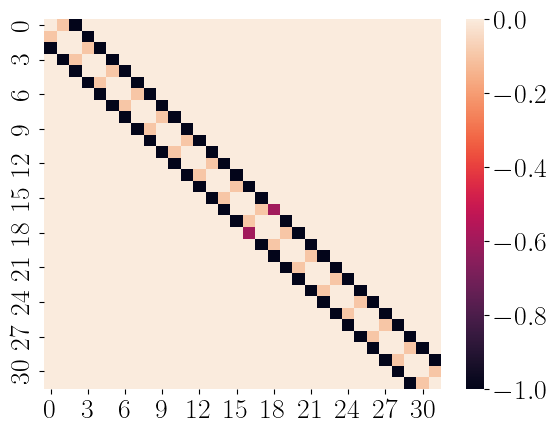

In [5]:
H_matrix = np.zeros((2*L_qpc,2*L_qpc))
# fill in the dd hopping only in odd diagonals
d_indices= kth_diag_indices(H_matrix,1)
H_matrix[d_indices] = -t

# fill in the QPC hopping
d_indices= kth_diag_indices(H_matrix,2)
H_matrix[d_indices] = -J[0]

# when qpc and qubit hop a the same time there is no contribution
d_indices= kth_diag_indices(H_matrix,1)
odd_inds = (d_indices[0][1::2], d_indices[1][1::2])
H_matrix[odd_inds] = 0


# Fill in the interaction at the bond
H_matrix[2*bond_index,2*(bond_index+1)] = H_matrix[2*bond_index,2*(bond_index+1)]+ Omega

# Now the elemets below the diagonal
for i in range(0,2*L_qpc):
    for j in range(i + 1, 2*L_qpc):
        H_matrix[j, i] = H_matrix[i, j]

print("Bond at: ", 2*bond_index)
sns.heatmap(H_matrix)


In [6]:
# Calculate the energies and eigenvectors
energies, eigen_vecs = np.linalg.eig(H_matrix)

print(energies)


[ 2.04041462  1.96289826  1.84304854  1.74931394  1.77916956  1.59328576
  1.53893225  1.36785246  1.28990238  1.10147443  0.96156203  0.76222355
  0.66152534  0.46297749  0.25738791  0.05081268 -0.05081268 -0.25738791
 -0.46297749 -2.04041462 -1.96289826 -0.66152534 -0.76222355 -1.84304854
 -1.77916956 -1.74931394 -0.96156203 -1.10147443 -1.59328576 -1.53893225
 -1.36785246 -1.28990238]


Here we expect two bands, however we have to be carefull because **linalg spits the eigenvectors and states all mixed up instead of in neat bands**. Since the compostie hamiltonian is of size 2*L the k-momenta of the QPC appear doubled, but this is just because we have two bands.

In [7]:
# Normalization of the zeroth order eigenstates
Norm = np.sqrt(2/(L_qpc+1))

# calculate the decoupled system analytic eigenenergies (zeroth order correction)
k_single_band = np.arange(1,L_qpc+1)*np.pi/(L_qpc+1)
em0 = -2*J[0]*np.cos(k_single_band) - t 
ep0 = -2*J[0]*np.cos(k_single_band) + t 

# separate into bands
energies_m, states_m = separate_band(energies,em0)
energies_p, states_p = separate_band(energies,ep0)

# find the momenta that we are mostly interested in (far from the edges of the brillouin zone)

_, cut1 = find_nearest(k_single_band, 0.3*np.pi)
_, cut2 = find_nearest(k_single_band, 0.7*np.pi)

## Zeroth Order

Text(0.5, 0, '$k$')

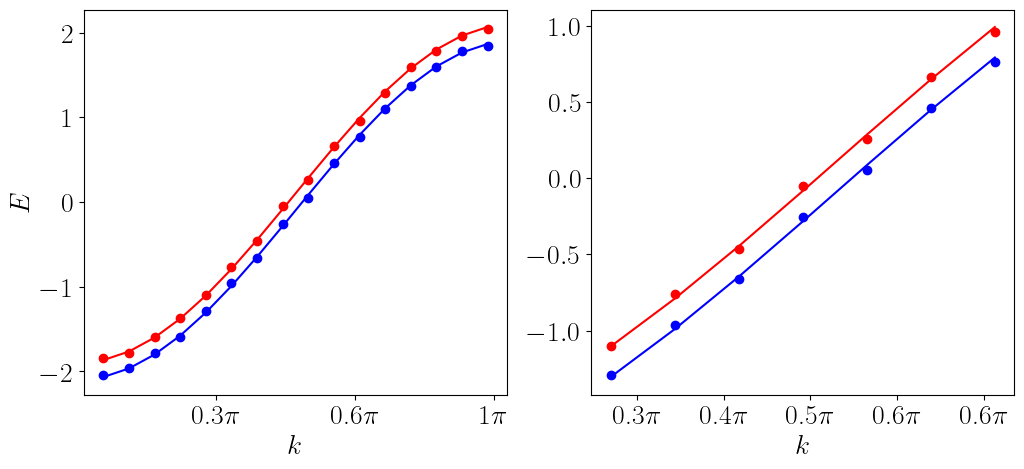

In [8]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

# zeroth order
ax[0].plot(k_single_band, em0, c= "blue")
ax[0].plot(k_single_band, ep0, c= "red")
# zoomed in 
ax[1].plot(k_single_band[cut1:cut2], em0[cut1:cut2], c= "blue")
ax[1].plot(k_single_band[cut1:cut2], ep0[cut1:cut2], c= "red")
           
# diagonalized
ax[0].scatter(k_single_band,energies_m, c= "blue")
ax[0].scatter(k_single_band,energies_p, c= "red")
# zoomed
ax[1].scatter(k_single_band[cut1:cut2],energies_m[cut1:cut2], c= "blue")
ax[1].scatter(k_single_band[cut1:cut2],energies_p[cut1:cut2], c= "red")



# write x axis in units of pi
ax[0].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))

ax[1].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))
ax[0].set_xlabel(r"$k$")
ax[0].set_ylabel(r"$E$")
ax[1].set_xlabel(r"$k$")


## First Order

here, both bands have the same correction. Notice how the perturbation is zero at some momenta namely **the perturbation is very small around $\pi/2$** and larger at the edges of the brillouin zone.

Text(0, 0.5, 'First Order Correction')

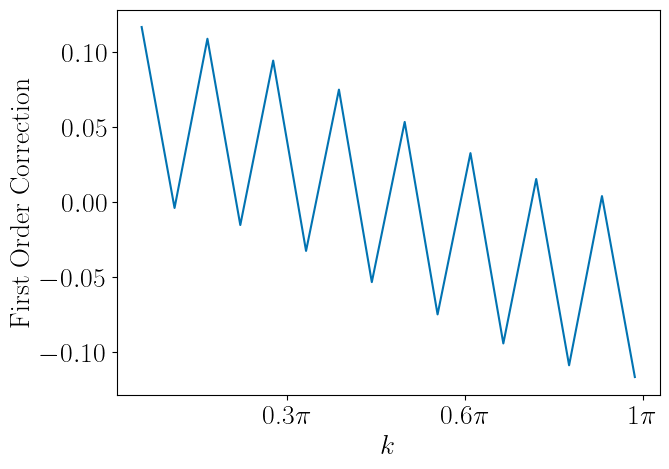

In [9]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

# First order corrections
e1 = (Norm**2)*np.sin(bond_index*k_single_band)*np.sin(bond_index*k_single_band+k_single_band)

plt.plot(k_single_band, e1)


ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,
                                                             pos: r'{:.0g}$\pi$'.format(val/np.pi)
                                                             if val !=0 else '0'))

plt.xlabel(r"$k$")
plt.ylabel(r"First Order Correction")

Text(0, 0.5, '$E$')

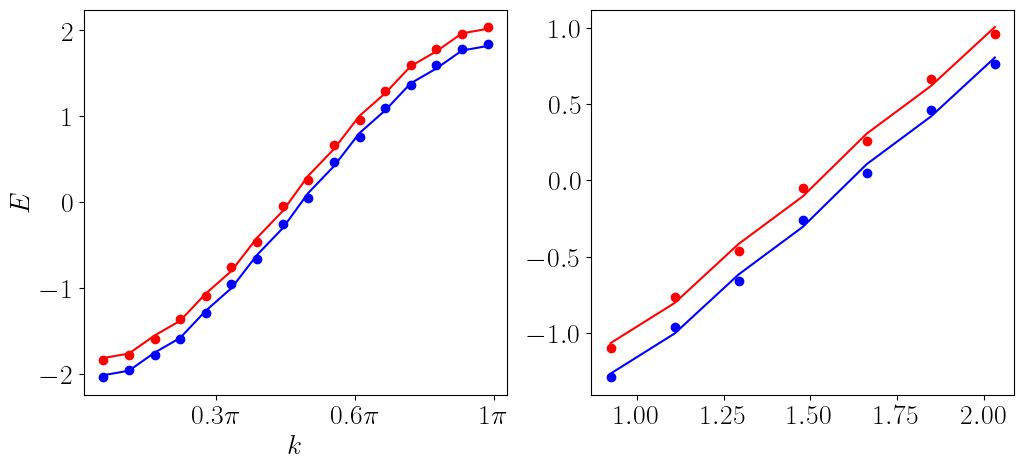

In [10]:
fig, ax = plt.subplots(1,2, figsize=(12,5))


# first order corrections
Em = em0 + Omega*e1
Ep = ep0 + Omega*e1

# normal
ax[0].scatter(k_single_band,energies_m, c= "blue")
ax[0].scatter(k_single_band,energies_p, c= "red")

ax[0].plot(k_single_band, Em, c= "blue")
ax[0].plot(k_single_band, Ep, c= "red")

# zoomed in 
ax[1].scatter(k_single_band[cut1:cut2],energies_m[cut1:cut2], c= "blue")
ax[1].scatter(k_single_band[cut1:cut2],energies_p[cut1:cut2], c= "red")

ax[1].plot(k_single_band[cut1:cut2], Em[cut1:cut2], c= "blue")
ax[1].plot(k_single_band[cut1:cut2], Ep[cut1:cut2], c= "red")


ax[0].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,
                                                             pos: r'{:.0g}$\pi$'.format(val/np.pi)
                                                             if val !=0 else '0'))

ax[0].set_xlabel(r"$k$")
ax[0].set_ylabel(r"$E$")

Text(0, 0.5, '$Errors$')

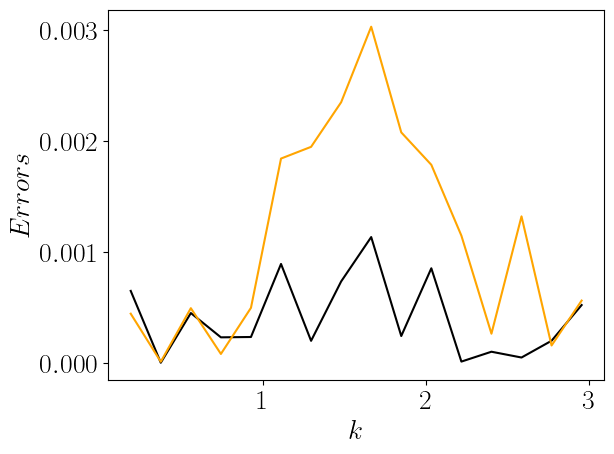

In [11]:
# plot the errors of the first correction vs zeroth order

Err0m = np.abs(energies_m - em0)**2
Err1m = np.abs(energies_m - Em)**2

plt.plot(k_single_band,Err0m, c="black")
plt.plot(k_single_band,Err1m, c="orange")

plt.xlabel(r"$k$")
plt.ylabel(r"$Errors$")

## Second Order

Due to the normalization factor these corrections are super small nad the longer the chain the smaller they become

In [12]:
def get_second_order(krange, eta, Bond):
    # eta is +-t depemndeing on the qubit states
    E2 = []

    for k in krange:
        # remove k so te sums don't blow up
        p_range = new_list = np.asarray([x for x in krange if x != k])
    
        T1 = (Norm**2)**2*(1/4)*np.sum( (xhi(k, p_range, Bond)**2)/(-2*J[0]*(np.cos(k)-np.cos(p_range))) )
        T2 = (Norm**2)**2*(1/4)*(1/(2*eta))*xhi(k,k,bond_index)**2
        T3 = (Norm**2)**2*(1/4)*np.sum( (xhi(k, p_range, Bond)**2)/(-2*J[0]*(np.cos(k)-np.cos(p_range))+2*eta) )
    
        E2.append(T1 + T2 + T3) 
        
    E2 = np.asarray(E2)
    
    return E2
    

In [13]:
def xhi(K,P, B):
    return np.sin(B*P+P)*np.sin(B*K) + np.sin(B*K+K)*np.sin(B*P)

e2p_correction = get_second_order(k_single_band, t, bond_index)

e2m_correction = get_second_order(k_single_band, -t, bond_index)

Text(0, 0.5, '$E$')

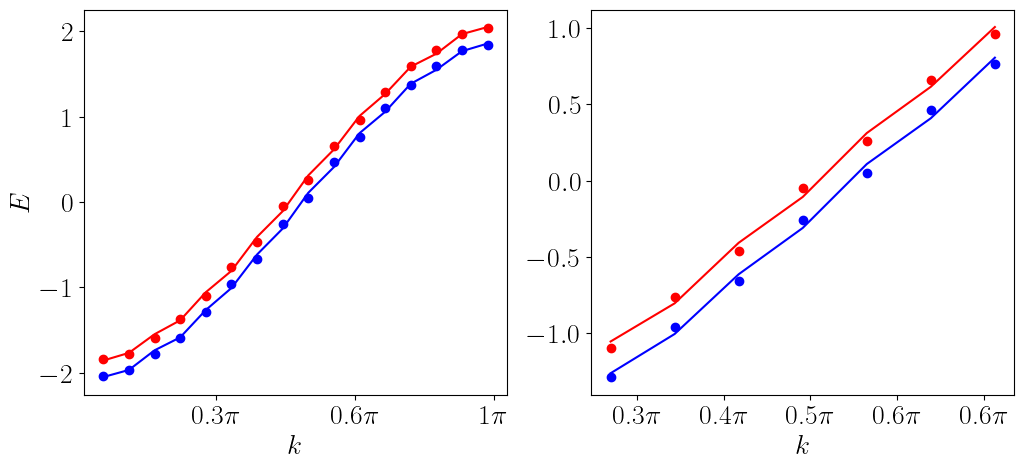

In [14]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

Ep2 = ep0 + Omega*e1 + (Omega**2)*e2p_correction
Em2 = em0 + Omega*e1 + (Omega**2)*e2m_correction

# normal
ax[0].scatter(k_single_band,energies_m, c= "blue")
ax[0].scatter(k_single_band,energies_p, c= "red")

ax[0].plot(k_single_band, Em2, c= "blue")
ax[0].plot(k_single_band, Ep2, c= "red")

# zoomed in 
ax[1].scatter(k_single_band[cut1:cut2],energies_m[cut1:cut2], c= "blue")
ax[1].scatter(k_single_band[cut1:cut2],energies_p[cut1:cut2], c= "red")

ax[1].plot(k_single_band[cut1:cut2], Em2[cut1:cut2], c= "blue")
ax[1].plot(k_single_band[cut1:cut2], Ep2[cut1:cut2], c= "red")


ax[0].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,
                                                             pos: r'{:.0g}$\pi$'.format(val/np.pi) 
                                                             if val !=0 else '0'))

ax[1].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,
                                                             pos: r'{:.0g}$\pi$'.format(val/np.pi) 
                                                             if val !=0 else '0'))
ax[0].set_xlabel(r"$k$")
ax[1].set_xlabel(r"$k$")

ax[0].set_ylabel(r"$E$")

Text(0, 0.5, '$Errors$')

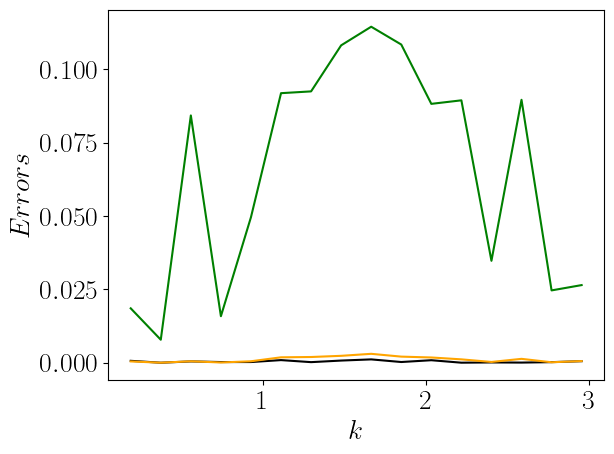

In [15]:
Err2m = np.abs(energies_m - Em2)*2

plt.plot(k_single_band,Err0m, c="black")
plt.plot(k_single_band,Err1m, c="orange")
plt.plot(k_single_band,Err2m, c="green")

plt.xlabel(r"$k$")
plt.ylabel(r"$Errors$")

# Scattering and Spread

Comparing the numerics with our mathematics

In [17]:
data_full_df = pd.read_csv('../data/exp_pro/exploration_data_L=21.csv')
data_full_df.rename(columns={"band_width": "x_spread"}, inplace=True)
data_full_df = data_full_df.drop(["Unnamed: 0"], axis=1).drop_duplicates()

print("Number of data points:", len(data_full_df))
data_full_df.head()


Number of data points: 1398


,L_qpc,max_time,tsteps,bond_index,x_spread,k0,J_prime,t,Omega,vg,...,bond_density_max,min_purity,max_VN_entropy,entanglement_timeskip,T_mean,ddot0,kick,theta_f,phi_f,delta_phi
0,21,18.0,400,7,0.5,0.392699,1.0,0.0,0.40,0.765367,...,0.535270,1.000000,8.992806e-15,10,0.951081,fixed,0.564233,2.107342e-08,0.000000,1.570796
1,21,18.0,400,7,0.5,0.981748,1.0,0.4,0.01,1.662939,...,0.543778,0.999962,2.238491e-04,10,0.802858,fixed,0.012193,2.895775e+00,1.535108,0.035688
2,21,18.0,400,7,2.0,0.392699,1.0,0.2,0.50,0.765367,...,0.367979,0.902862,2.020031e-01,10,0.827560,fixed,0.834754,1.550818e+00,-1.090803,2.661600
3,21,18.0,400,7,0.5,0.981748,1.0,0.1,0.05,1.662939,...,0.541525,0.998104,7.552377e-03,10,0.801953,fixed,0.060610,2.291796e+00,1.488497,0.082299
4,21,18.0,400,7,2.0,0.392699,1.0,0.3,0.10,0.765367,...,0.363672,0.994725,1.833645e-02,10,0.872464,fixed,0.171816,6.310212e-01,1.405248,0.165548


In [33]:
data_full_df.columns

Index(['L_qpc', 'max_time', 'tsteps', 'bond_index', 'x_spread', 'k0',
       'J_prime', 't', 'Omega', 'vg', 'time_at_bond', 'bond_fit_error',
       'time_f_free', 'time_f_int', 'xf_avg_free', 'xf_avg_int',
       'Transmision_tot', 'Transmission_k0', 'r_density_free', 'r_density_int',
       'last_density_free', 'last_density_int', 'last_density_max',
       'time_last_density_max', 'bond_density_max', 'min_purity',
       'max_VN_entropy', 'entanglement_timeskip', 'T_mean', 'ddot0', 'kick',
       'theta_f', 'phi_f', 'delta_phi'],
      dtype='object')

In [125]:
Deltax = 2.0
bindex = data_full_df["bond_index"].unique()[0]
vg_list = sorted(data_full_df.vg.unique())
k_list = sorted(data_full_df.k0.unique())
meff = 1/(2*J*np.cos(k_list))

tau_predict = np.sqrt(2*np.log(2))*0.5*Deltax**2*(1+(bindex/(vg_list*meff*Deltax**2))**2 )

tau_predict= np.sqrt(2*np.log(2))*(Deltax**2 + 0.5*((1/np.tan(k_list))*bindex/Deltax)**2)

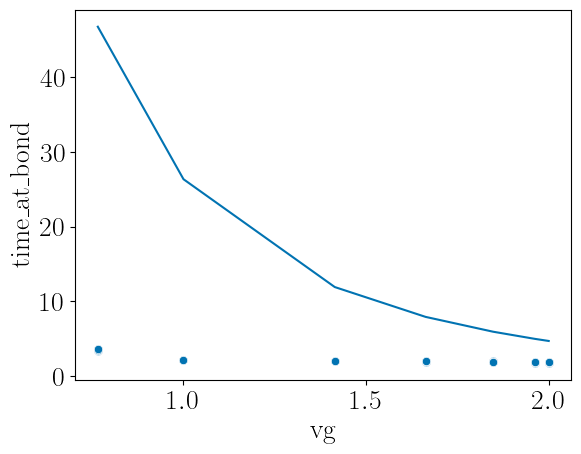

In [126]:
curr_df = data_full_df[ (data_full_df["x_spread"]==2.0) ]
sns.scatterplot(curr_df, x="vg", y="time_at_bond")
plt.plot(vg_list, tau_predict)


# Looking at the pre measurement gained phase

In [16]:
"res_L21_maxtim18.0_bw2.0_k0.5236_jp1.0_t0.1_om0.3_dd0fixed.hdf5"
"res_L21_maxtim18.0_bw2.0_k0.7854_jp1.0_t0.1_om0.3_dd0fixed.hdf5"
"res_L21_maxtim18.0_bw2.0_k1.1781_jp1.0_t0.1_om0.3_dd0fixed.hdf5"
"res_L21_maxtim18.0_bw2.0_k1.5708_jp1.0_t0.1_om0.3_dd0fixed.hdf5"

file_name = "res_L21_maxtim18.0_bw2.0_k0.7854_jp1.0_t0.1_om0.3_dd0fixed.hdf5"

param_dict, times, n_bond, n_left, n_right, n_d1, n_d2, traject, VN_entropy, purity,\
                dd_costheta, dd_sinphi = load_data(data_route,file_name)
J=1

# calculate data for the time scales
tau_L, tau_free, tau_b, vg, x_av, bond_root  = get_timescale_data(param_dict, traject, times, n_bond)                        
xvg = vg*times # trajectory using group velocity


14.849242404917499 0.7853981633974483
phi is undefined using next values


## Approximating the spread with the FWHM

# Ancilla